# Problem: Detecting fraudulent app usage data with STL and confidence intervals
You are given app usage data, tracking the daily active users. You want to determine anomlies that are indicative of any suspicious activity, such as bots.

We will use Seasonal Trend Decomposition (STL)  decomposition and combine it with statistical methods to detect anomalies in time-series data.  




This code imports essential Python libraries for data analysis, visualization, and time series decomposition:

STL from statsmodels.tsa.seasonal is used for for Seasonal-Trend decomposition of time series data.








In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from statsmodels.tsa.seasonal import STL

In the next cell, load the dataset from the file and display its contents to examine the data structure.


Following code converts the 'timestamp' column in the DataFrame df to a datetime format using pandas.to_datetime(), ensuring that the values are recognized as datetime objects for easier time-based operations and analysis


In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])


Use the following code to display the first few rows of the updated DataFrame and verify the modifications:


Following  code creates a pandas Series named dau using the values from the 'daily_active_users' column of the DataFrame df, setting the 'timestamp' column as the index to enable time series operations.


In [ ]:
dau = pd.Series(data=df['daily_active_users'].values, index=df['timestamp'])


In the next cell, plot the dau data using the Matplotlib library. Ensure that the plot includes appropriate labels for the x-axis and y-axis, as well as a suitable title.



The code dau.describe() is calling the .describe() method on a DataFrame named dau.



In [ ]:
dau.describe()


Folloiwng code decomposes the time series data dau into trend, seasonal, and residual components using the STL method, specifying weekly seasonality (period=7), and stores the results in res.


In [ ]:
stl = STL(dau, period=7)  # weekly seasonality
res = stl.fit()



In the following cell, print the different time series components.

In [ ]:
print(res.seasonal)
# Your code to print trend component
# Your code to print residual component. res.resid is the residual component
print (res.resid)

Following code, creates the plot of various time series components like, trend, seasonality, and residual.

In [ ]:
#plot 4 components, original, residual, trend, and noise using matplotlib

fig = res.plot()
fig.set_size_inches(12, 5)
plt.show()

Following code is used for minor anomaly detection by defining an upper and lower threshold around the trend component of the time series. These thresholds, trend_iv_l_minor and trend_iv_u_minor, are set by adjusting the trend with the mean and standard deviation of the residuals. Values outside this range can be considered anomalies, as they deviate significantly from the expected trend behavior.

In [ ]:
trend_iv_l_minor = pd.Series(data=res.trend.values-np.mean(res.trend)-np.std(res.resid), index=res.trend.index)
trend_iv_u_minor = pd.Series(data=res.trend.values-np.mean(res.trend)+np.std(res.resid), index=res.trend.index)\

minor_anom = np.where((res.resid < trend_iv_l_minor) | (res.resid > trend_iv_u_minor), res.resid, np.nan)


Bsed on the above code, write Python code to find anomalies that are 2 times and 3 times away from standard deviation. Use trend component for detecting anomalies.

Using a similar approach, write Python code to detect anomalies using the Z-score method. Apply 2-3 threshold values to detect anomalies, using the residual component for detection. Note that the formula for the Z-score is:
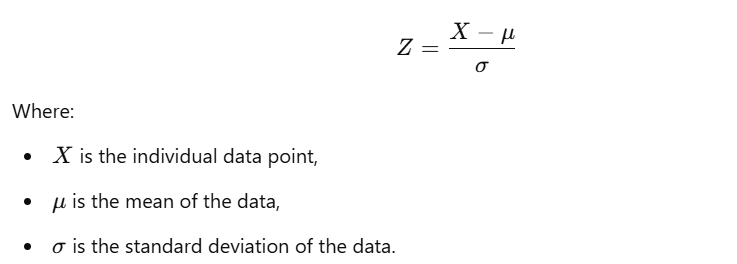

A point x is anomaly if Z-score for that point is greater than threshold.


#Important: Lab Logbook Requirement:
#Plot the anomalies in next cell and include this graph in your lab logbook."

Using a similar approach, write Python code to detect anomalies using the IQR method. Apply 2-3 threshold values to detect anomalies, using the residual component for detection. Note that the formula for the IQR is:

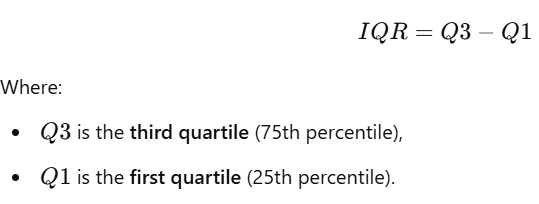

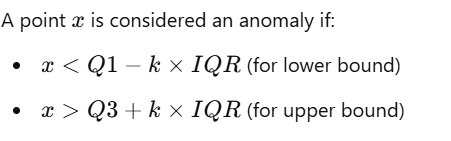

#Important: Lab Logbook Requirement:
#Plot the anomalies in next cell and include this graph in your lab logbook."

## Folooing section is optional for this lab.

The code below uses Linear Regression. Based on the following code write your own code to detect anomalies in using ARIMA which is also one of the regression algorithm.

ARIMA is a model used to predict future value in a time series.
It looks at past data to find patterns and trends.

AR (AutoRegressive): Uses past values to predict future ones.
I (Integrated): Makes the data more stable by removing trends.
MA (Moving Average): Uses past errors (differences between actual and predicted values) to improve predictions.

You can use the Python library statsmodels.tsa.arima.model to implement ARIMA.
https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

You need to compare the ARIMA prediction and actual values and if they are significantly different then the points can be considered as anomolous.







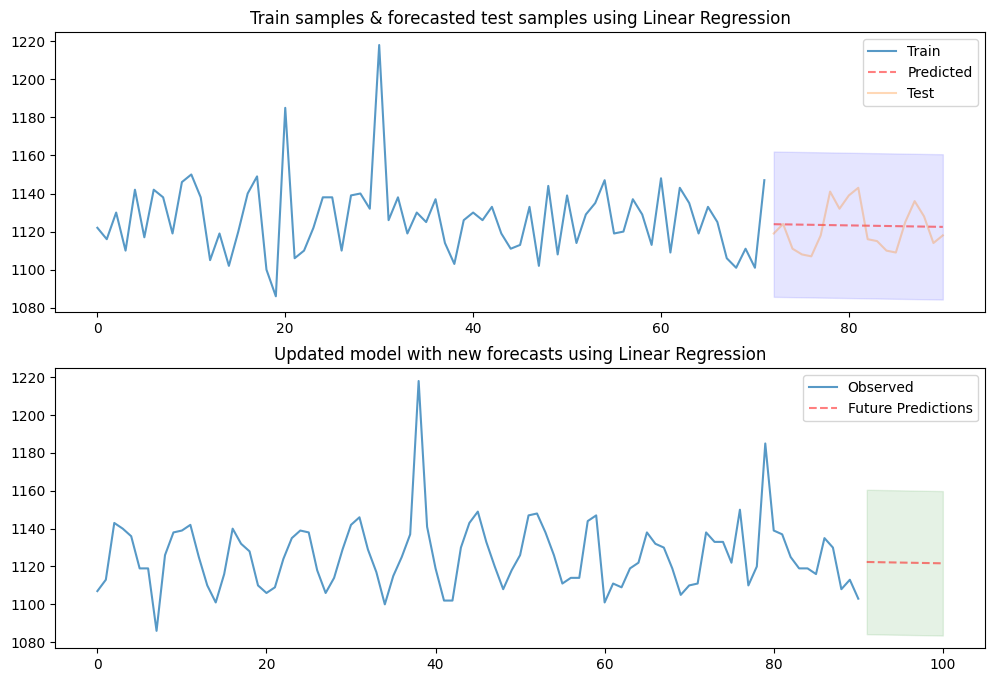

MSE for Linear Regression Forecast: 133.6046


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Splitting data into train and test
train, test = train_test_split(dau.values, train_size=0.8, random_state=42)

# Creating time indices as features for regression
train_indices = np.arange(len(train)).reshape(-1, 1)
test_indices = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)

# Training linear regression model
model = LinearRegression()
model.fit(train_indices, train)

# Making predictions
preds = model.predict(test_indices)

# Calculating confidence intervals (assuming normal distribution of residuals)
residuals = train - model.predict(train_indices)
std_dev = np.std(residuals)
conf_int = np.column_stack((preds - 1.96 * std_dev, preds + 1.96 * std_dev))

# Plotting results
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
x_axis = np.arange(len(train) + len(test))
axes[0].plot(x_axis[:len(train)], train, alpha=0.75, label="Train")
axes[0].plot(x_axis[len(train):], preds, alpha=0.5, linestyle='--', color='r', label="Predicted")
axes[0].plot(x_axis[len(train):], test, alpha=0.3, label="Test")
axes[0].fill_between(x_axis[len(train):], conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b')
axes[0].set_title("Train samples & forecasted test samples using Linear Regression")
axes[0].legend()

# Detecting anomalies
anomalies = (test < conf_int[:, 0]) | (test > conf_int[:, 1])
axes[0].scatter(x_axis[len(train):][anomalies], test[anomalies], color='red', label="Anomalies")

# Updating model with test data and predicting future values
new_indices = np.arange(len(dau.values), len(dau.values) + 10).reshape(-1, 1)
new_preds = model.predict(new_indices)
new_conf_int = np.column_stack((new_preds - 1.96 * std_dev, new_preds + 1.96 * std_dev))

axes[1].plot(np.arange(len(dau.values)), dau, alpha=0.75, label="Observed")
axes[1].plot(new_indices, new_preds, alpha=0.5, linestyle='--', color='r', label="Future Predictions")
axes[1].fill_between(new_indices.flatten(), new_conf_int[:, 0], new_conf_int[:, 1], alpha=0.1, color='g')
axes[1].set_title("Updated model with new forecasts using Linear Regression")
axes[1].legend()
plt.show()

# Compute MSE
mse_linear = mean_squared_error(test, preds)
print(f"MSE for Linear Regression Forecast: {mse_linear:.4f}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA

# Load dataset
df = pd.read_csv(r"D:\downloads\product_usage_data.csv")  # Replace with actual file path
df['timestamp'] = pd.to_datetime(df['timestamp'])
dau = pd.Series(data=df['daily_active_users'].values, index=df['timestamp'])

# Plot the data
dau.plot(title='Daily Active Users', xlabel='Date', ylabel='Users', figsize=(12, 6))
plt.show()

# STL decomposition
stl = STL(dau, period=7)
res = stl.fit()

# Plot decomposition
fig = res.plot()
fig.set_size_inches(12, 5)
plt.show()

# Minor anomaly detection
trend_iv_l_minor = res.trend - np.mean(res.trend) - np.std(res.resid)
trend_iv_u_minor = res.trend - np.mean(res.trend) + np.std(res.resid)
minor_anom = np.where((res.resid < trend_iv_l_minor) | (res.resid > trend_iv_u_minor), res.resid, np.nan)

# Plot minor anomalies
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(res.resid, marker='.', linestyle='none', label='Residuals')
ax.plot(pd.Series(minor_anom, res.resid.index), marker='o', linestyle='none', label='Minor Anomalies', color='blue', fillstyle='none', markersize=8)
ax.fill_between(res.resid.index, trend_iv_l_minor, trend_iv_u_minor, color='grey', alpha=0.5, label='Confidence Interval')
ax.set_title('Minor Anomalies (90% Confidence Interval)')
ax.legend()
plt.show()

# Anomaly detection using standard deviation (2σ and 3σ)
threshold_2sigma = np.std(res.resid) * 2
threshold_3sigma = np.std(res.resid) * 3

anomalies_2sigma = res.resid[(res.resid > threshold_2sigma) | (res.resid < -threshold_2sigma)]
anomalies_3sigma = res.resid[(res.resid > threshold_3sigma) | (res.resid < -threshold_3sigma)]

# Plot anomalies (2σ and 3σ)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(res.resid, marker='.', linestyle='none', label='Residuals')
ax.plot(anomalies_2sigma, 'ro', label='Anomalies (2σ)')
ax.plot(anomalies_3sigma, 'go', label='Anomalies (3σ)')
ax.set_title('Anomalies using 2σ and 3σ thresholds')
ax.legend()
plt.show()

# Anomaly detection using Z-score method
z_scores = zscore(res.resid)
z_thresholds = [2, 3]

for z_th in z_thresholds:
    anomalies_z = res.resid[np.abs(z_scores) > z_th]
    plt.figure(figsize=(12, 6))
    plt.plot(res.resid, marker='.', linestyle='none', label='Residuals')
    plt.plot(anomalies_z, 'ro', label=f'Anomalies (Z-score > {z_th})')
    plt.title(f'Anomalies using Z-score (Threshold = {z_th})')
    plt.legend()
    plt.show()

# Anomaly detection using IQR method
Q1 = np.percentile(res.resid, 25)
Q3 = np.percentile(res.resid, 75)
IQR = Q3 - Q1
k_values = [1.5, 3]

for k in k_values:
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    anomalies_iqr = res.resid[(res.resid < lower_bound) | (res.resid > upper_bound)]
    plt.figure(figsize=(12, 6))
    plt.plot(res.resid, marker='.', linestyle='none', label='Residuals')
    plt.plot(anomalies_iqr, 'ro', label=f'Anomalies (IQR k={k})')
    plt.title(f'Anomalies using IQR (k={k})')
    plt.legend()
    plt.show()

# ARIMA-based anomaly detection
train_size = int(len(dau) * 0.8)
train, test = dau[:train_size], dau[train_size:]

model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()
preds = model_fit.forecast(steps=len(test))
residuals = test - preds

std_res = np.std(residuals)
anomalies_arima = residuals[(np.abs(residuals) > 2 * std_res)]

# Plot ARIMA anomalies
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual')
plt.plot(preds, linestyle='dashed', label='Predicted')
plt.plot(anomalies_arima, 'ro', label='Anomalies')
plt.title('Anomalies using ARIMA')
plt.legend()
plt.show()


Traceback (most recent call last):
  File "c:\Users\muham\.vscode\extensions\ms-python.python-2025.0.0-win32-x64\python_files\python_server.py", line 133, in exec_user_input
    retval = callable_(user_input, user_globals)
  File "<string>", line 4, in <module>
ModuleNotFoundError: No module named 'statsmodels'



Traceback (most recent call last):
  File "c:\Users\muham\.vscode\extensions\ms-python.python-2025.0.0-win32-x64\python_files\python_server.py", line 133, in exec_user_input
    retval = callable_(user_input, user_globals)
  File "<string>", line 1
    !pip install statsmodels
    ^
SyntaxError: invalid syntax

